In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Loading data

In [2]:
df = pd.read_csv("data/housing.csv")

Visualising the head (top 5)

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Show samples (and possible misses)

In [4]:
df.count()

longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
dtype: int64

What them features do?

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [5]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 20640 rows and 10 columns


### Plotting Graph Functions (self made)

In [6]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    # Select columns to plot
    columns = df.select_dtypes(include=[np.number]).columns[:nGraphShown]
    
    # Calculate number of rows needed
    nGraphRow = (len(columns) - 1) // nGraphPerRow + 1
    
    # Create subplots with larger figure size
    fig, axes = plt.subplots(nGraphRow, nGraphPerRow, figsize=(7*nGraphPerRow, 6*nGraphRow))
    axes = axes.flatten() if nGraphRow > 1 or nGraphPerRow > 1 else [axes]
    
    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].tick_params(labelsize=8)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plotCorrelationMatrix(df):
    # Select numerical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_columns) < 2:
        print("Error: The DataFrame must have at least two numeric columns to create a correlation matrix.")
        return
    
    # Create a new dataframe with numeric columns
    df_numeric = df[numeric_columns]
    
    # Handle missing values
    df_numeric = df_numeric.dropna()
    
    # Calculate the correlation matrix
    corr_matrix = df_numeric.corr()
    
    # Mask the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 10))
    
    # Create a heatmap of the correlation matrix with the mask
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    
    plt.title('Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print information about non-numeric columns
    non_numeric_columns = [col for col in df.columns if col not in numeric_columns]
    if non_numeric_columns:
        print("\nNon-numeric columns excluded from the correlation matrix:")
        for col in non_numeric_columns:
            print(f"- {col} (type: {df[col].dtype})")

def plotScatterMatrix(df, plotSize, textSize):
    # Keep only numerical columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with NaN values
    df = df.dropna(axis=1)
    
    # Keep columns where there are more than 1 unique values
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    # Limit to 10 columns
    columnNames = list(df.columns)
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    df = df[columnNames]
    
    # Create the scatter matrix
    fig, ax = plt.subplots(nrows=len(columnNames), ncols=len(columnNames), figsize=(plotSize, plotSize))
    pd.plotting.scatter_matrix(df, alpha=0.75, diagonal='kde', ax=ax)
    
    # Add correlation coefficients
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), 
                          xycoords='axes fraction', ha='center', va='center', 
                          size=textSize)
    
    plt.suptitle('Scatter and Density Plot', fontsize=textSize*1.5)
    plt.tight_layout()
    plt.show()

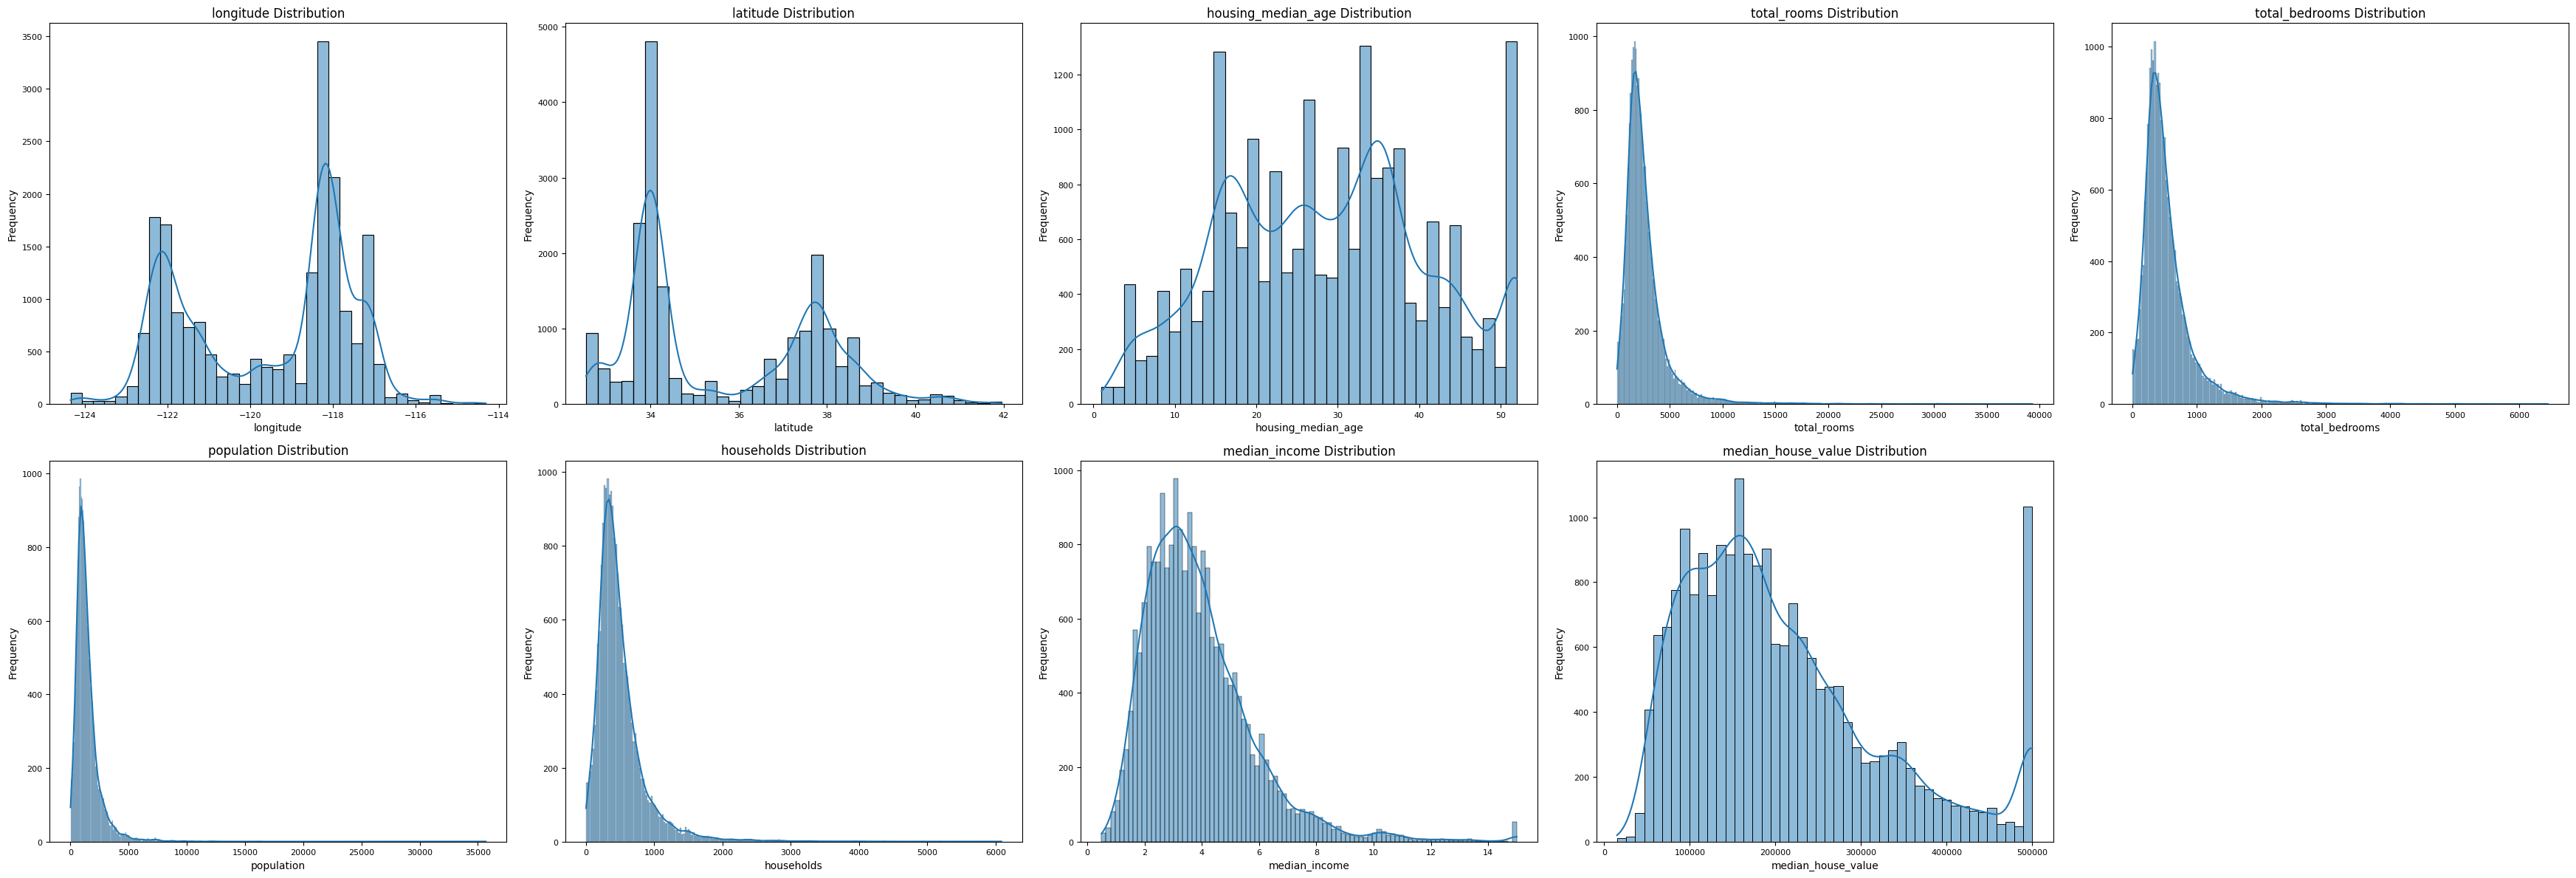

In [7]:
plotPerColumnDistribution(df, 10, 5)

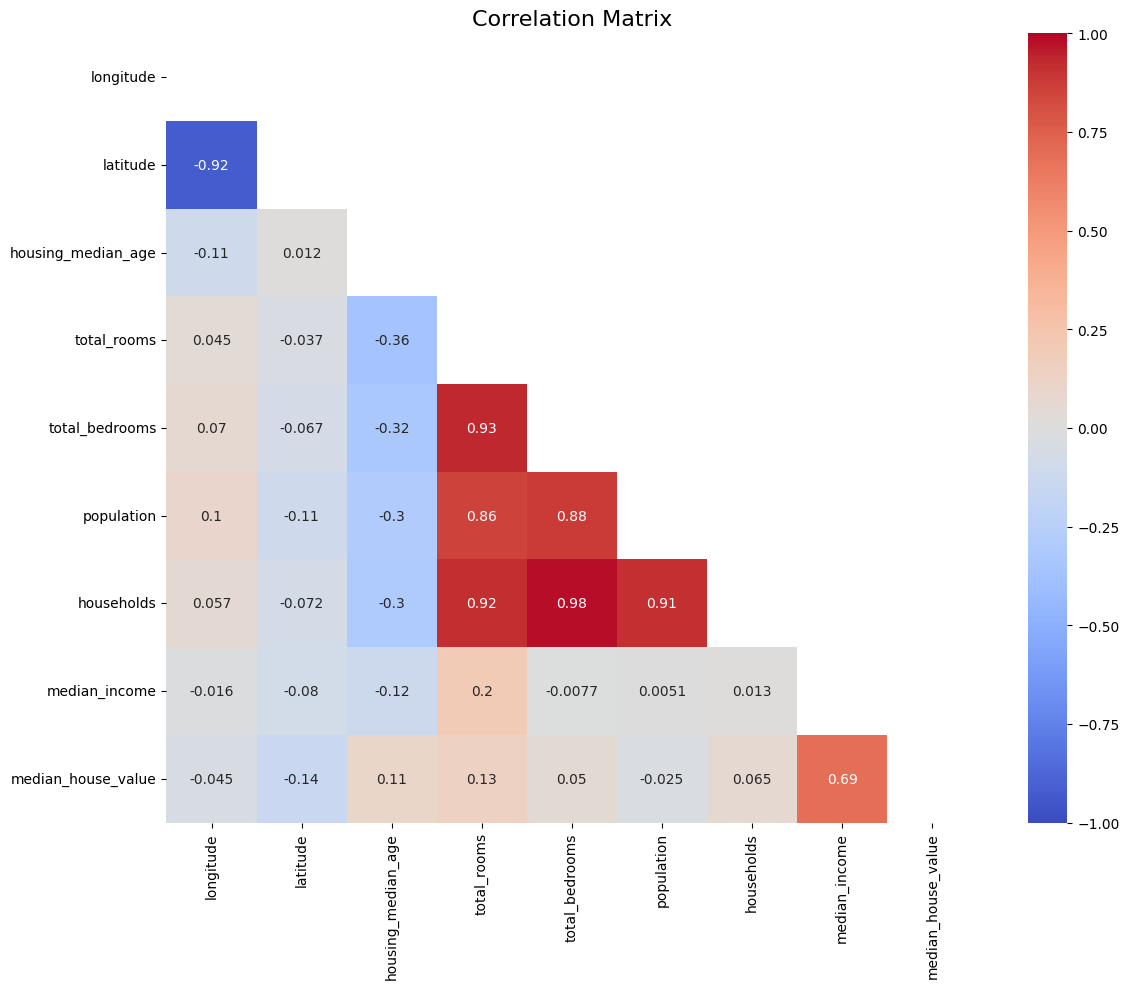


Non-numeric columns excluded from the correlation matrix:
- ocean_proximity (type: object)


In [8]:
plotCorrelationMatrix(df)

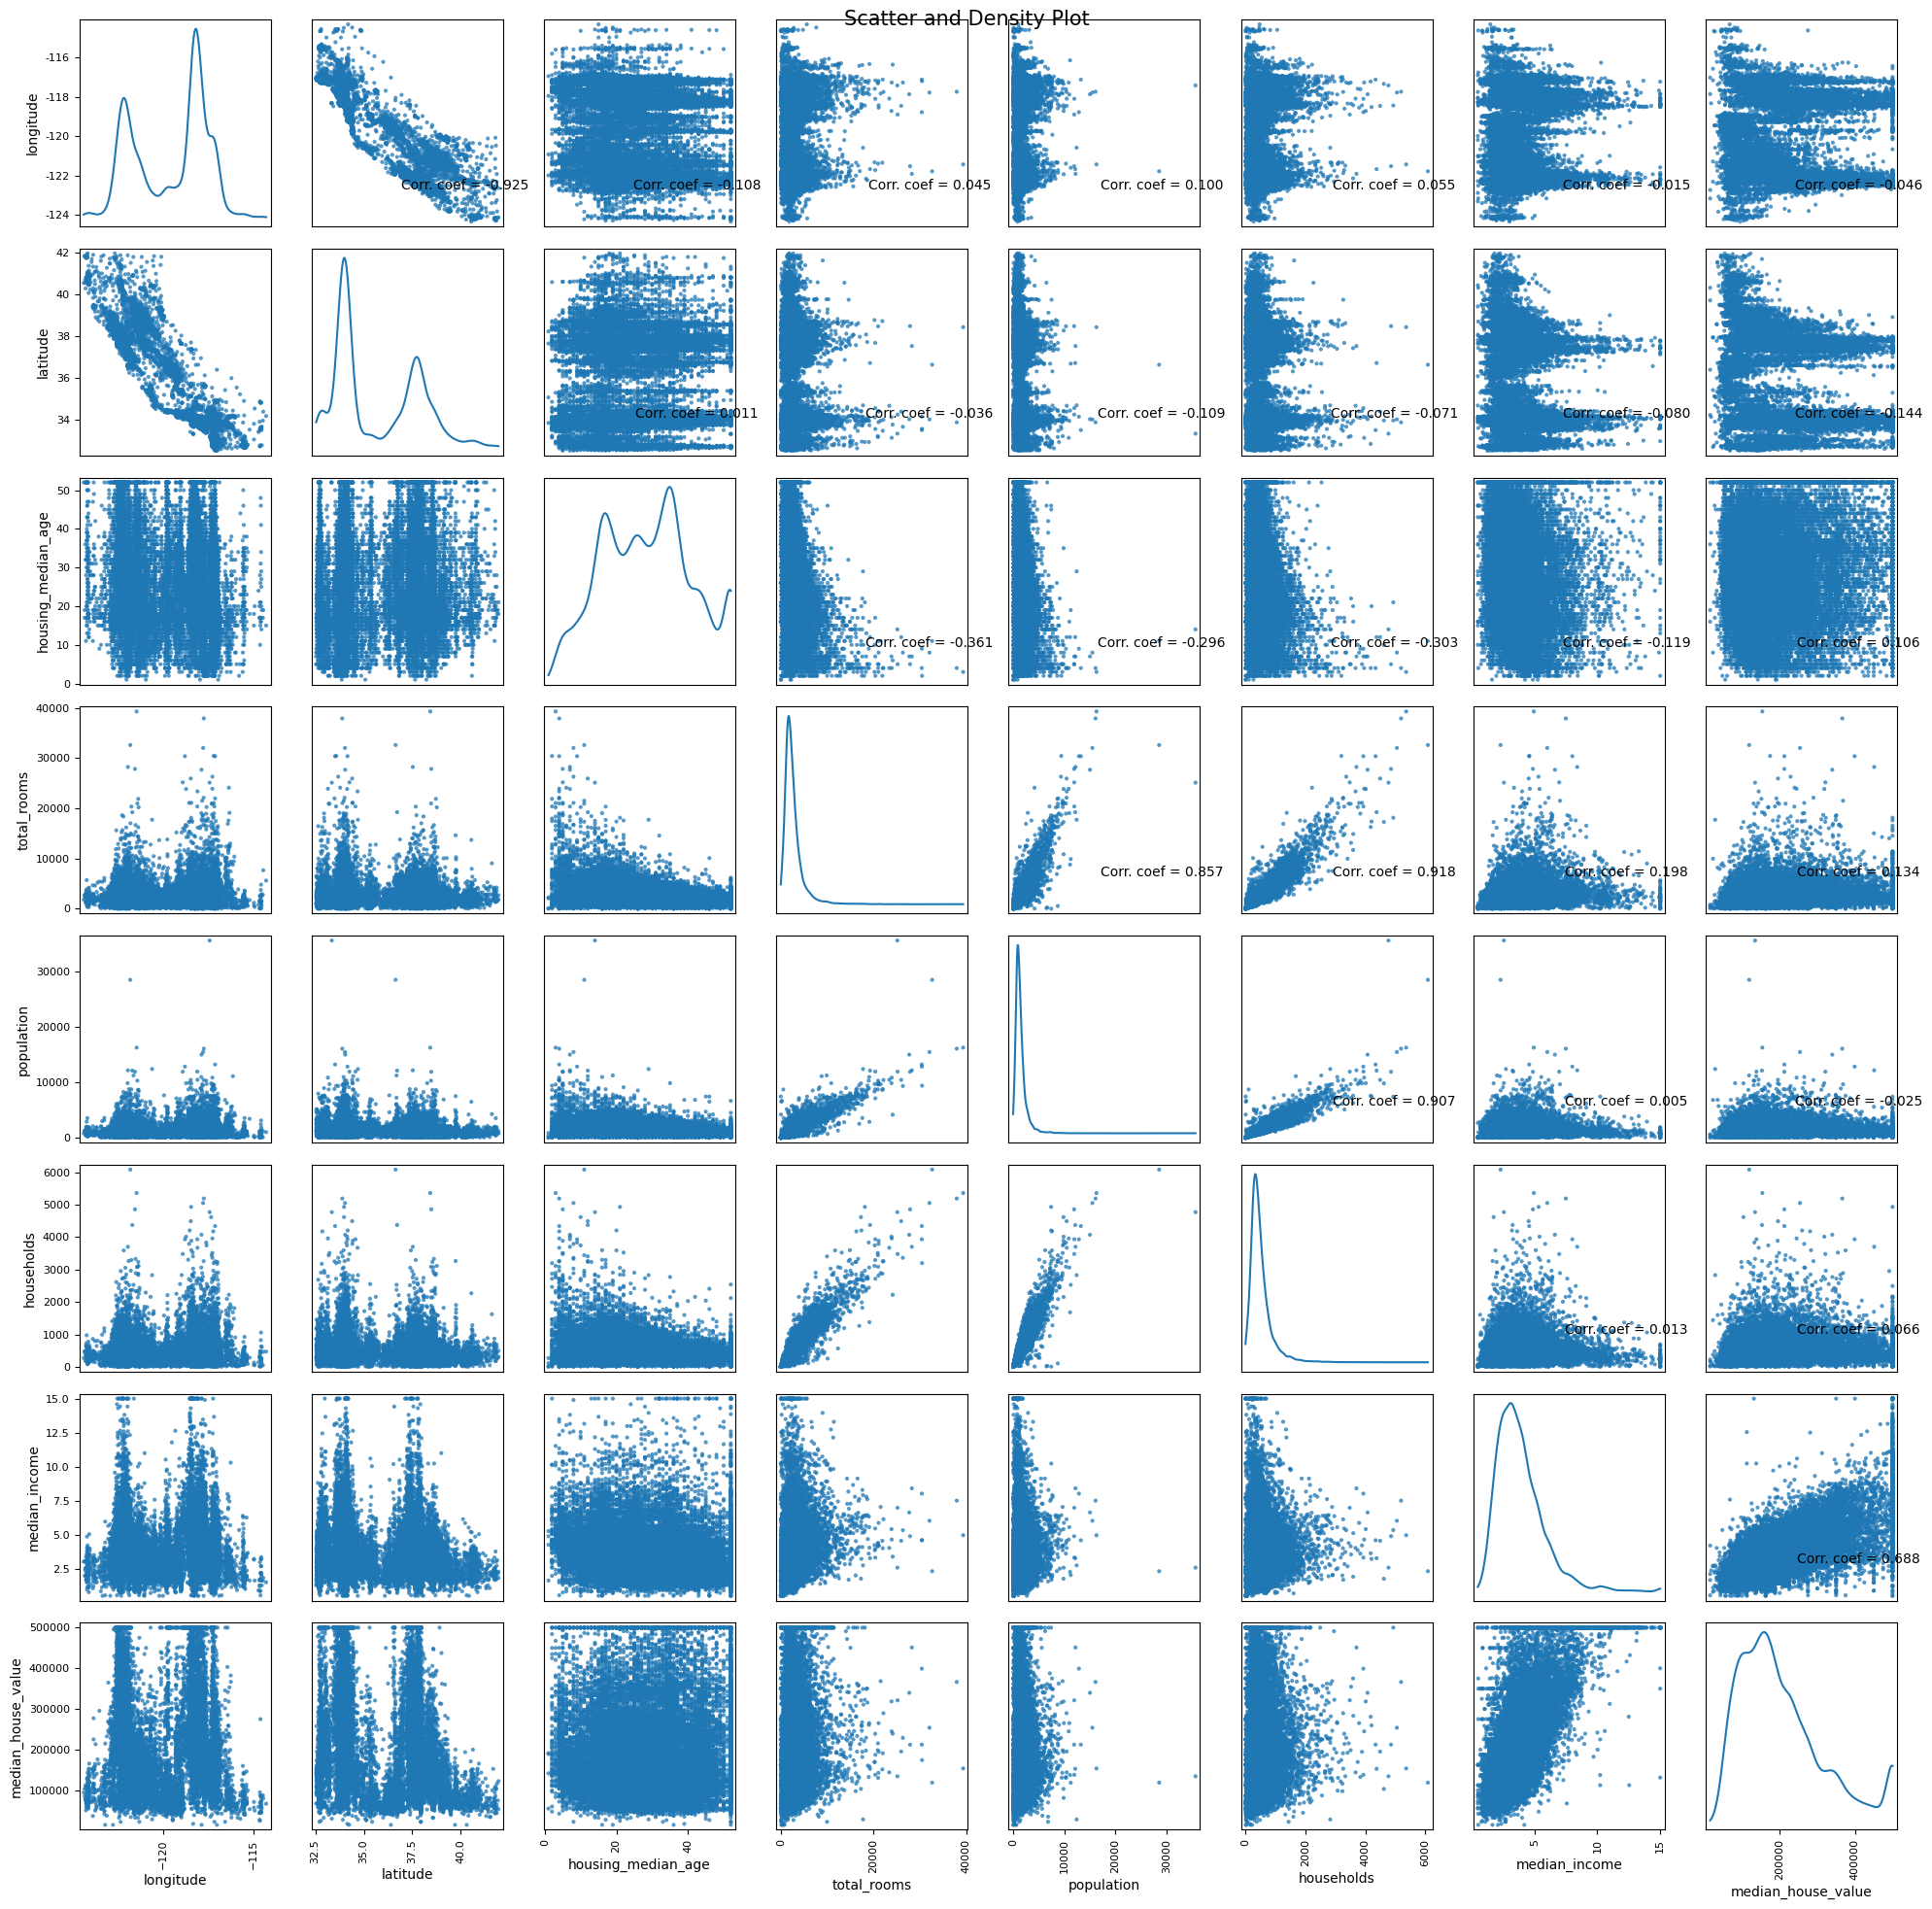

In [9]:
plotScatterMatrix(df, 20, 10)

<center><font size=11> CH2. Finding (& visualising) missings </font> </center>


### 2.1 Numerical Summary

In [10]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent
get_numerical_summary(df)

total_bedrooms : 207 (1.003%)


{'total_bedrooms': 1.002906976744186}

### 2.2 Matrix

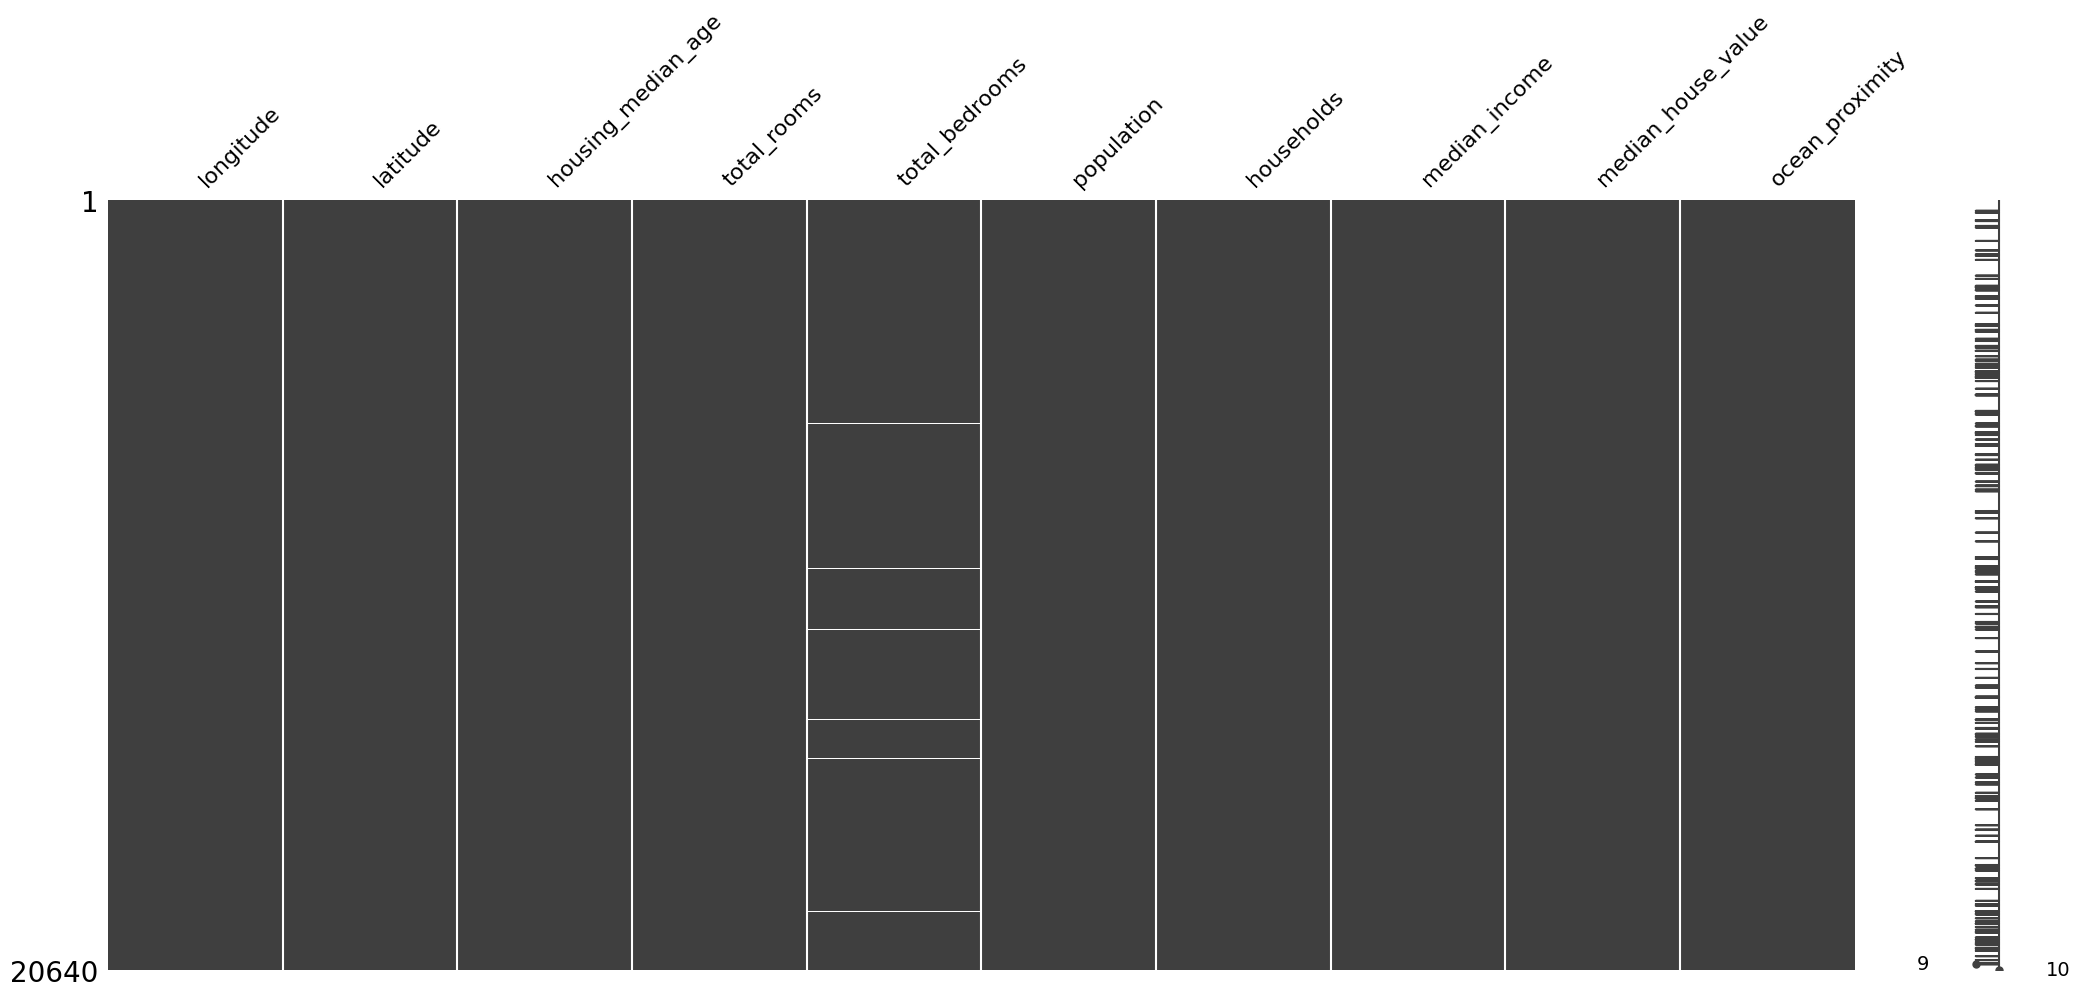

<Figure size 1500x900 with 0 Axes>

In [12]:
msno.matrix(df)
plt.figure(figsize = (15,9))
plt.show()

### 2.3 Nullify Correlation
vergelijkt alleen columns met missing data (useful bij >1 columns w NAN/Missing)

<Axes: >

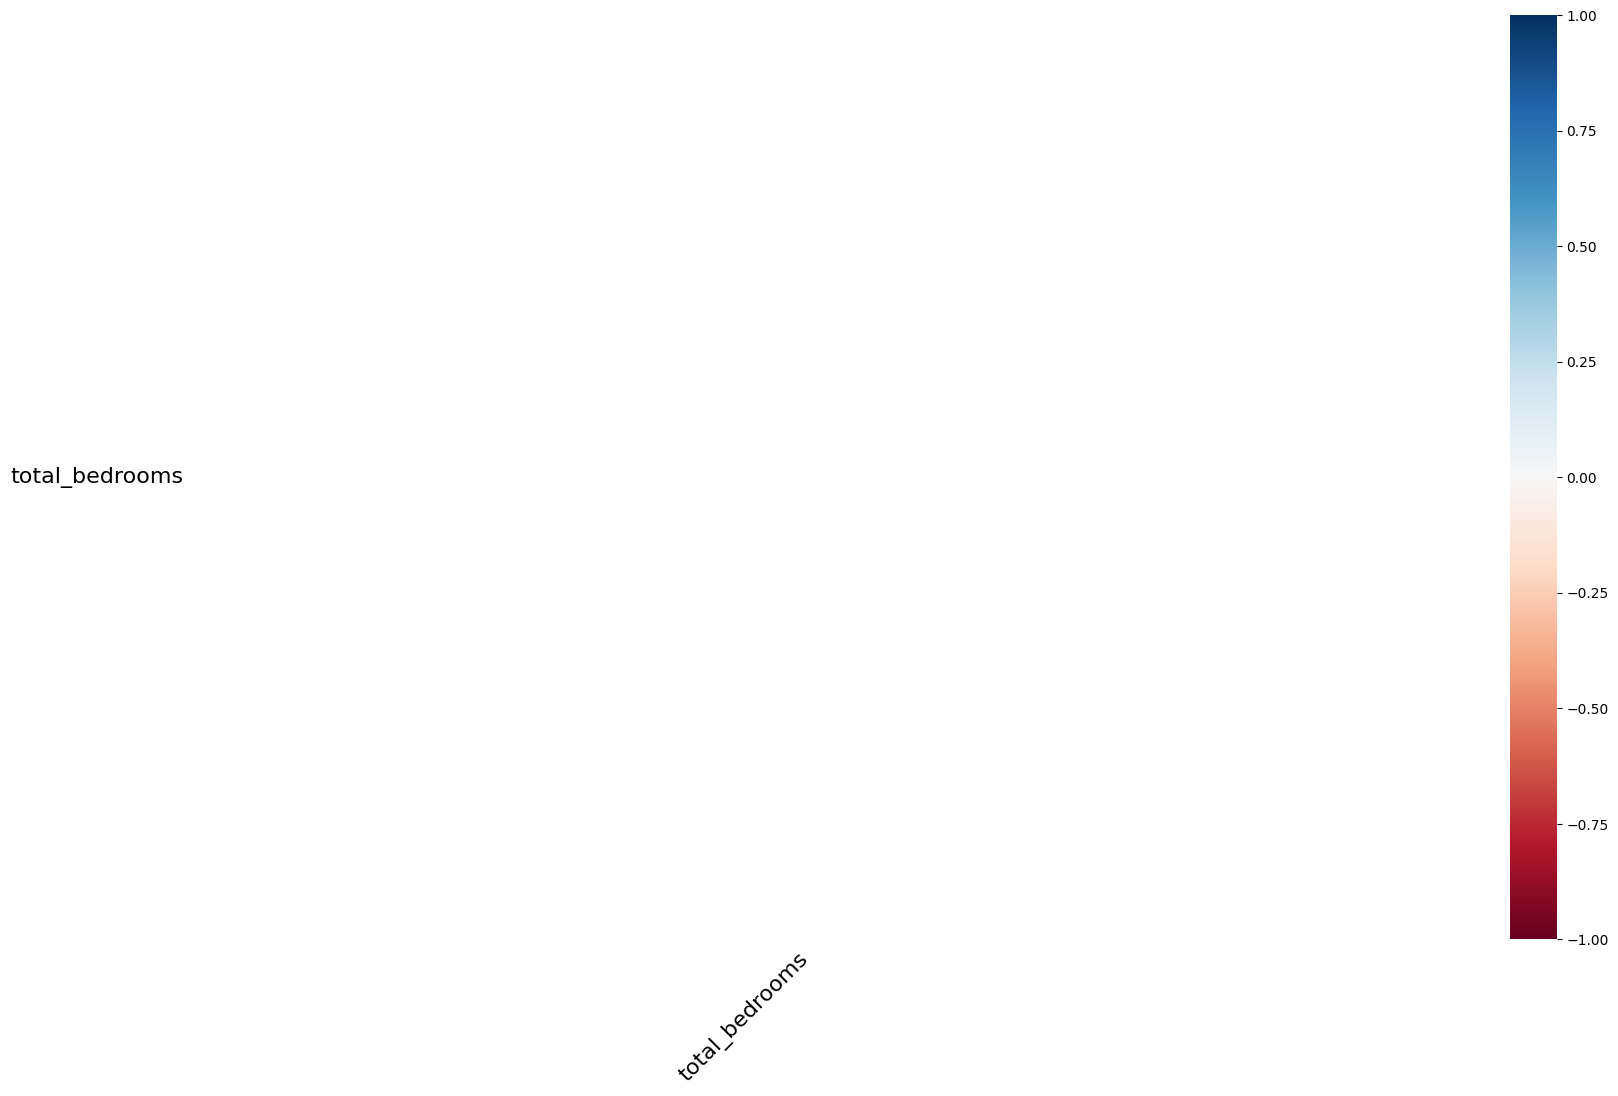

In [13]:
msno.heatmap(df, labels = True)

### 2.4 Dendrogram
WIP

<center><font size=11> CH3 Cleaning the data</font> </center>

### 3.1 MISSINGS

Drop de rows in een specifieke subset (COL) met NA values 

In [14]:
df = df.dropna(subset=['total_bedrooms'])

In [15]:
df.count()

longitude             20433
latitude              20433
housing_median_age    20433
total_rooms           20433
total_bedrooms        20433
population            20433
households            20433
median_income         20433
median_house_value    20433
ocean_proximity       20433
dtype: int64

### 3.2 OUTLIERS

<font color=green size=6> Plotting </font>  <font size=6> Boxplots </font>

> 1 columns showing incorrect? NAN's.


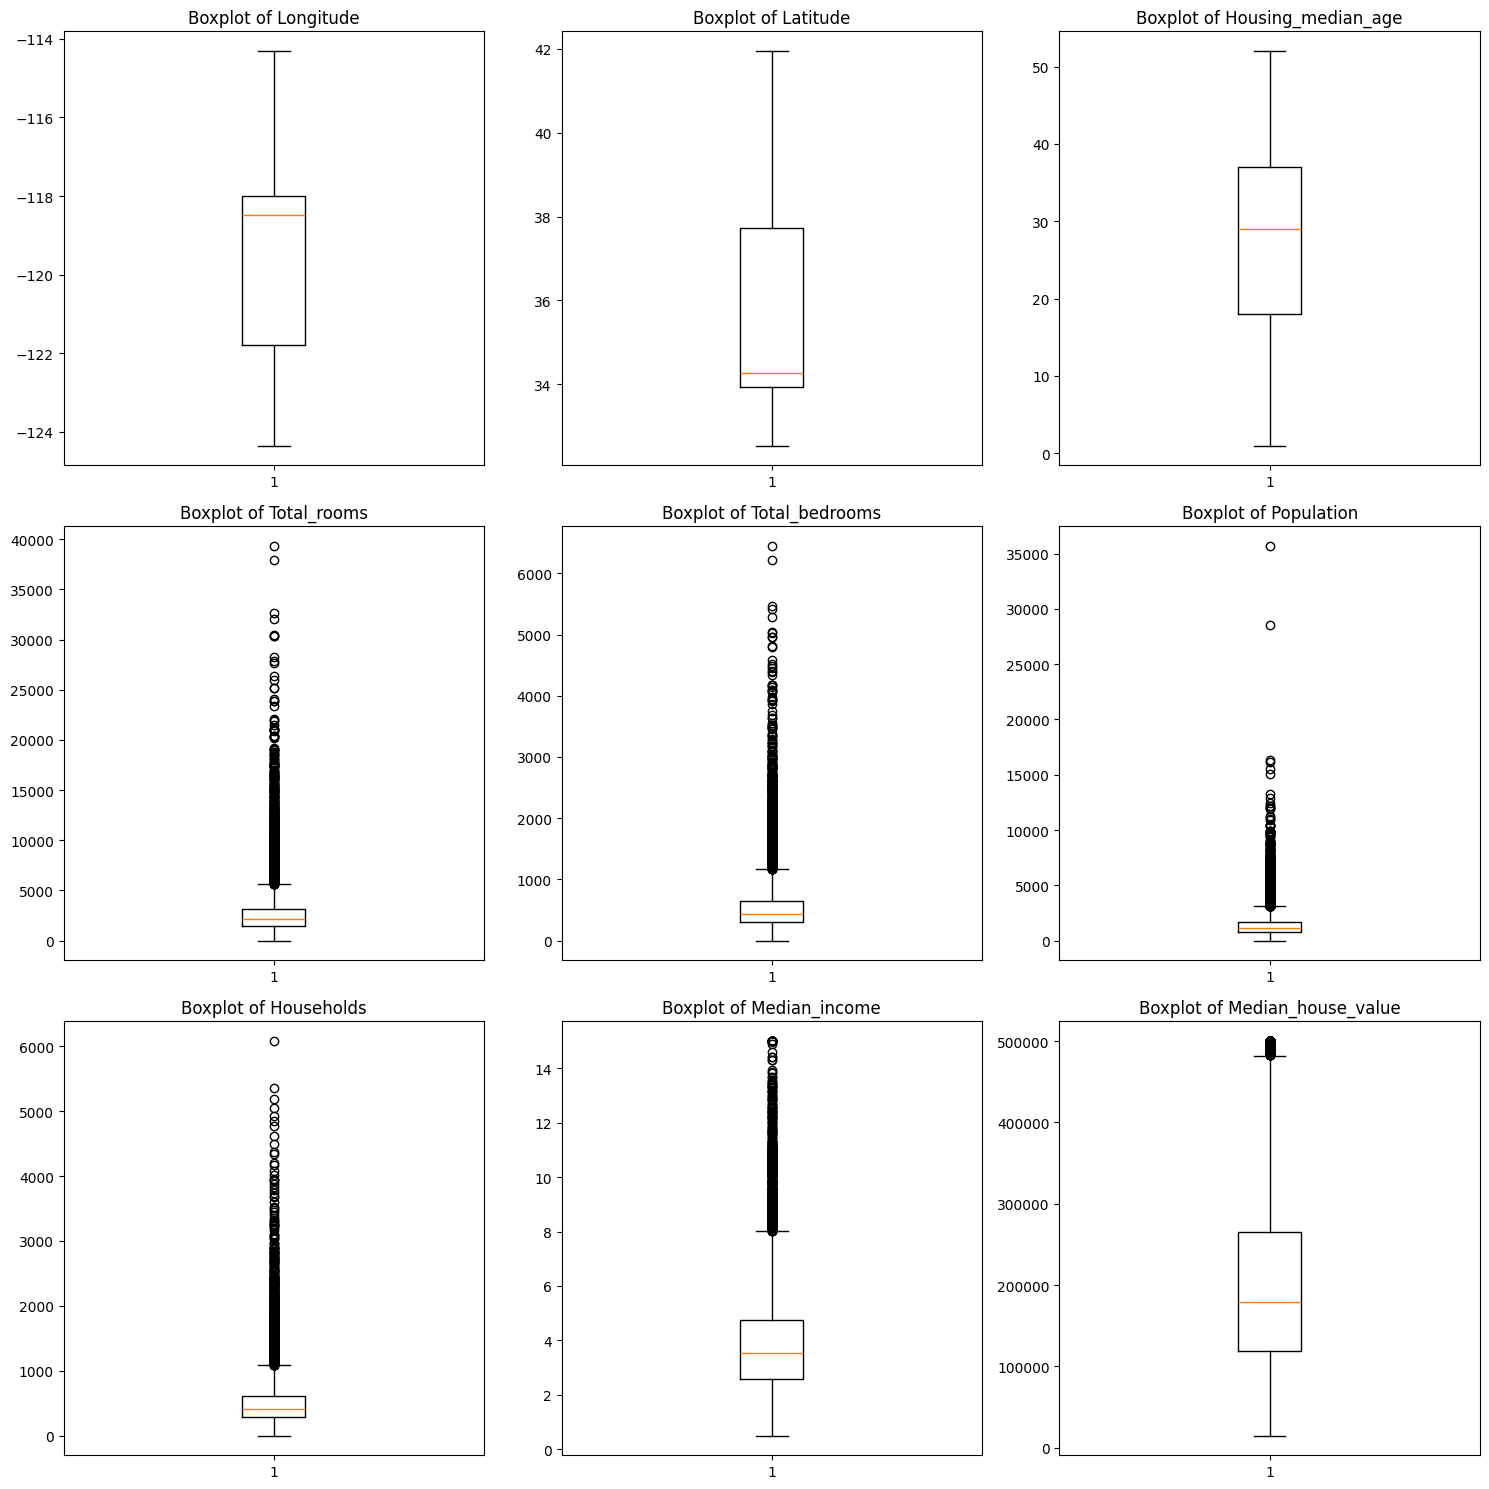

In [16]:
def plot_numeric_boxplots(df):
    """
    Plot boxplots for all numeric columns in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    None
    """
    # Select only numeric columns
    df_numeric = df.select_dtypes(include=[np.number])

    # Determine the number of numeric columns
    num_columns = len(df_numeric.columns)

    # Calculate the number of rows needed, 3 columns per row
    num_rows = (num_columns + 2) // 3

    # Create the subplots dynamically
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    # Flatten the axes array to iterate over each subplot
    axes = axes.flatten()

    # Plot boxplots for each numeric column
    for i, col in enumerate(df_numeric.columns):
        axes[i].boxplot(df_numeric[col].dropna(), vert=True)  # Drop NaN values for plotting
        axes[i].set_title(f'Boxplot of {col.capitalize()}')
        axes[i].set_ylabel('')  # Remove y-label for cleaner presentation

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_numeric_boxplots(df)

<font color=red size=6> Cleaning </font>  <font size=6> Outliers ~ Boxplots </font>

* to research. hierbij actual data aan het vernietigen, GEEN FAN.

In [17]:
# Function to remove outliers based on IQR
def remove_outliers(df):
    cleaned_data = pd.DataFrame()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Checking numerical columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            cleaned_data[col] = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col]
        else:
            cleaned_data[col] = df[col]  # Non-numeric columns remain unchanged
    return cleaned_data
# Applying outlier removal function to the entire dataset
df = remove_outliers(df)

In [18]:
df.count()

longitude             20433
latitude              20433
housing_median_age    20433
total_rooms           19143
total_bedrooms        19162
population            19243
households            19223
median_income         19763
median_house_value    19369
ocean_proximity       20433
dtype: int64

In [19]:
df = df.dropna()

In [20]:
df.count()

longitude             17434
latitude              17434
housing_median_age    17434
total_rooms           17434
total_bedrooms        17434
population            17434
households            17434
median_income         17434
median_house_value    17434
ocean_proximity       17434
dtype: int64

<font color=red size=6> TO DO: </font>  
<font size=3>
* After outliers, many NAN's 
* Nu zijn de core statistics (median, mean, etc) ook veranderd. Dus nieuwe outliers. Niet opnieuw cleanen toch?

</font>


<center> <font size=11> CH4. LABEL ENCODING </font> </center>
<center> <font color=red> * label encoding eerst doen voor correlation matching? </font></center>

## WIP

In [21]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [22]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df['ocean_proximity']=lb.fit_transform(df['ocean_proximity'])

In [23]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,3
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


Building the model

In [26]:
x=df.drop(columns='median_house_value').values
x.shape

(17434, 9)

In [38]:
y=df['median_house_value'].values
y.shape

ValueError: Type must be a sub-type of ndarray type

Train_Test_Split

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

Scaling

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
x_train=torch.FloatTensor(x_train)
x_test=torch.FloatTensor(x_test)
y_train=torch.FloatTensor(y_train).view(-1, 1)
y_test=torch.FloatTensor(y_test).view(-1, 1)

In [45]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


torch.Size([13947, 9])
torch.Size([3487, 9])
torch.Size([13947, 1])
torch.Size([3487, 1])


In [32]:
class House_prediction(nn.Module):
    def __init__(self,input_feature=9,hidden_layer1=20,hidden_layer2=20,output_feature=1):
        super(House_prediction,self).__init__()
        self.fc1=nn.Linear(input_feature,hidden_layer1)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(hidden_layer1,hidden_layer2)
        self.relu2=nn.ReLU()
        self.fc3=nn.Linear(hidden_layer2,output_feature)

    def forward(self,x):
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        return x

In [33]:
model=House_prediction()

In [34]:
model.parameters

<bound method Module.parameters of House_prediction(
  (fc1): Linear(in_features=9, out_features=20, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)>

In [35]:
import torch.optim as optim
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

In [36]:
epochs=500
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model.forward(x_train)
    loss=criterion(y_pred,y_train)
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

c:\Users\mhous\Projects\github\RNN\venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([13947])) that is different to the input size (torch.Size([13947, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number: 1 and the loss : 43834830848.0
Epoch number: 11 and the loss : 43834302464.0
Epoch number: 21 and the loss : 43832283136.0
Epoch number: 31 and the loss : 43826290688.0
Epoch number: 41 and the loss : 43811807232.0
Epoch number: 51 and the loss : 43782414336.0
Epoch number: 61 and the loss : 43729289216.0


KeyboardInterrupt: 